Make sure you fill your name and NetID below:

In [1]:
NAME = "Vikram Sahai Saxena"
NET_ID = "vs799"

---

This assignment is worth a total of **170 points**, there is an optional 20 points of extra credit that you can choose to complete or not.
1. Part I: Camera Calibration using a 3D calibration object (**50 points**)
2. Part II: Camera Calibration using 2D calibration object (**70 points**)
3. Part III: Augmented Reality 101 (**50 points**)
4. Extra credit (**20 points**)


In some cells you will see code blocks that look like this:

```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
x = 3.7
# END OF YOUR CODE
```


When completing the notebook, please adhere to the following rules:
- You should replace the `pass` statement with your own code and leave the blocks intact.
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has not been run.

**Please rename the submission file as \<netid\>.ipynb**.

In [2]:
# Uncomment the following if you are working on colab
!pip install tadasets
!pip install opencv-contrib-python

# Uncomment the following if you are not working on colab
# !pip install google-colab

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgba2rgb
import cv2
from skimage.feature import peak_local_max

from sklearn.metrics.pairwise import euclidean_distances
import numpy.linalg as linalg
from numpy.linalg import svd
import math

try:
    from google.colab.patches import cv2_imshow
except:
    def cv2_imshow(image):
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()

from sklearn.metrics.pairwise import euclidean_distances

In [5]:
content_path = "materials"
solution_dict = np.load(f'{content_path}/solution_dict.npy', allow_pickle=True).item()

# Part I: Camera Calibration using a 3D calibration object (50 points)

We want to calibrate the camera of a robot vehicle using a linear method as described in the lectures. We place a large cubic frame of size 4 meters on the road several meters in front of the vehicle. The positions of the eight corners of the cubic frame are defined with respect to a world coordinate system with its axes parallel to the cube edges and with its origin at the center of the cube. The world coordinates of the cube vertices are:

- (2, 2, 2)
- (-2, 2, 2)
- (-2, 2, -2)
- (2, 2, -2)
- (2, -2, 2)
- (-2, -2, 2)
- (-2, -2, -2)
- (2, -2, -2)

We detect the corresponding cube corners at the following pixel positions in the camera image:

- (422, 323)
- (178, 323)
- (118, 483)
- (482, 483)
- (438, 73)
- (162, 73)
- (78, 117)
- (522, 117)



1. Draw the image points, using small circles for each image point. Feel free to use the `plotPts`

422 323
178 323
118 483
482 483
438 73
162 73
78 117
522 117


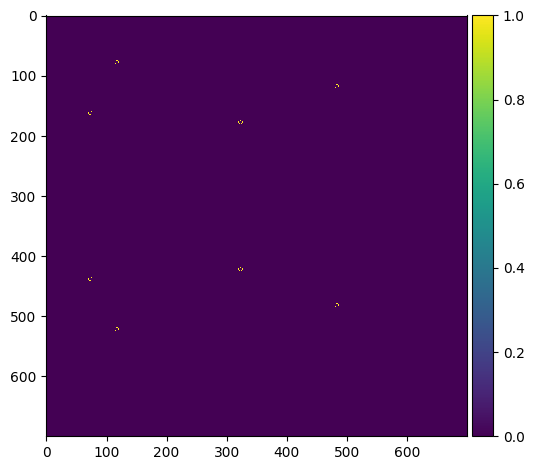

In [7]:
def plotPts(pts, image, pt=True):
    for i, j in pts:
        wand = 3 # width of point, with (i, j) in centre (helps to make the point visible on the plot)
        if pt:
            print(i, j)
        # Replace "pass" statement with your code
        from skimage.draw import circle_perimeter
        row, col = circle_perimeter(i, j, wand)
        image[row, col] = 1
        # END OF YOUR CODE
    io.imshow(image)
    io.show()
    return


camera_image = np.zeros((700,700))
#422 323; 178 323; 118 483; 482 483; 438 73; 162 73; 78 117; 522 117
cube_corners = [[422, 323], [178, 323],[118, 483], [482, 483], [438, 73], [162, 73], [78, 117], [522 ,117]]
#2 2 2, -2 2 2, -2 2 -2,  2 2 -2, 2 -2 2, -2 -2 2, -2 -2 -2, 2 -2 -2
real_cube_corners = [[2,2,2],[-2,2,2],[-2,2,-2],[2,2,-2],[2,-2,2],[-2,-2,2],[-2,-2,-2],[2,-2,-2]]
plotPts(cube_corners,camera_image,True)

**Grader will grade the above code based on the plot you show. Please neglect "YOU ANSWER HERE"**

YOUR ANSWER HERE

2. Complete the function `P_generator(x,y,z,u,v)` that takes as argument the homogeneous coordinates of one cube corner and the homogeneous coordinates of its image, and returns 2 rows of the matrix $\mathbf{P}$ (slide 30 of the Camera Calibration pdf document). This matrix $\mathbf{P}$ will be used to compute the 12 elements of the projection matrix $\mathbf{M}$ such that $\lambda P_i = \mathbf{M}P_i$.

3. Use this function to generate 2 rows of the matrix $\mathbf{P}$ for each cube corner and its image and obtain a matrix with 16 rows and 12 columns. Print matrix $\mathbf{P}$.

In [8]:
def P_generator(x, y, z, u, v):
    # 12 columns
    P_temp = np.zeros((2, 12))
    # Replace "pass" statement with your code
    P_temp[0, :] = [x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u]
    P_temp[1, :] = [0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v]
    # END OF YOUR CODE
    return P_temp

P = None
first = True
for i in range(len(cube_corners)):
    x, y, z = real_cube_corners[i]
    u, v = cube_corners[i]
    if first:
        P = P_generator(x, y, z, u, v)
        first = False
    else:
        P_temp = P_generator(x, y, z, u, v)
        P = np.append(P, P_temp, axis=0)
print("P matrix:\n",P)

P matrix:
 [[ 2.000e+00  2.000e+00  2.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00 -8.440e+02 -8.440e+02 -8.440e+02 -4.220e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  2.000e+00  2.000e+00
   2.000e+00  1.000e+00 -6.460e+02 -6.460e+02 -6.460e+02 -3.230e+02]
 [-2.000e+00  2.000e+00  2.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  3.560e+02 -3.560e+02 -3.560e+02 -1.780e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -2.000e+00  2.000e+00
   2.000e+00  1.000e+00  6.460e+02 -6.460e+02 -6.460e+02 -3.230e+02]
 [-2.000e+00  2.000e+00 -2.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  2.360e+02 -2.360e+02  2.360e+02 -1.180e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -2.000e+00  2.000e+00
  -2.000e+00  1.000e+00  9.660e+02 -9.660e+02  9.660e+02 -4.830e+02]
 [ 2.000e+00  2.000e+00 -2.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00 -9.640e+02 -9.640e+02  9.640e+02 -4.820e+02]
 [ 0.000e+00  0.000e+00  0.000

In [9]:
assert np.all(np.abs(solution_dict['P'] - P) < 1e-3)

4. Now we need to solve the system $\mathbf{P}m=0$. Find the singular value decomposition of matrix P using a `svd` function available in the python package `numpy.linalg`. The last column vector of V obtained by `svd(P)` should be the 12 elements in row order of the projection matrix that transformed the cube corner coordinates into their images. Reshape and Print the matrix $\mathbf{M}$.

In [10]:
# We will assign the correct values to necessary variables even if the previous calculation is incorrect or shifted
# due to compounding deviations, ensuring that students can still proceed with following parts of the coding.

P = solution_dict['P']

In [11]:
#SVD
u,s,vh =svd(P)

m = None
# Replace "pass" statement with your code
m = vh[-1, :].reshape(3, 4)
# END OF YOUR CODE
print("M matrix:\n",m)

M matrix:
 [[1.92485371e-01 2.82704820e-02 7.86051209e-02 7.34592038e-01]
 [2.42367403e-07 2.04411170e-01 6.91856900e-05 6.12009747e-01]
 [9.73362960e-10 9.42349769e-05 2.62017163e-04 2.44863818e-03]]


In [12]:
assert np.all(np.abs(solution_dict['m']) - np.abs(m) < 1e-6)

5. Now we need to recover the translation vector which is a null vector of M. Find the singular value decomposition of matrix $M = U \Sigma V^T$. The 4 elements of the last column of V are the homogeneous coordinates of the position of the camera center of projection in the frame of reference of the cube (as in slide 36). Print the corresponding 3 Euclidean coordinates of the camera center in the frame of reference of the cube.

In [13]:
# We will assign the correct values to necessary variables even if the previous calculation is incorrect or shifted
# due to compounding deviations, ensuring that students can still proceed with following parts of the coding.

m = solution_dict['m']

In [14]:
um,sm,vhm =svd(m)
V = np.transpose(vhm)
xcoor, ycoor, zcoor, dcoor = V[:,-1]
world_origin_in_cam = []
# Replace "pass" statement with your code
world_origin_in_cam = [xcoor / dcoor, ycoor / dcoor, zcoor / dcoor]
# END OF YOUR CODE
print("origin of the world in camera",world_origin_in_cam)
print('origin of camera in world',[-c for c in world_origin_in_cam])

origin of the world in camera [-4.41163992400343e-06, -2.9912142958562753, -8.269539081833305]
origin of camera in world [4.41163992400343e-06, 2.9912142958562753, 8.269539081833305]


In [15]:
assert np.all(np.abs(np.array(solution_dict['world_origin_in_cam']) - np.array(world_origin_in_cam)) < 1e-3)

6. Consider the $3 \times 3$ matrix $\mathbf{M}'$ composed of the first 3 columns of matrix $\mathbf{M}$. Rescale the elements of this matrix so that its element $m_{33}$ becomes equal to 1. Print matrix M’.

In [16]:
Mprime = None
# Replace "pass" statement with your code
Mprime = m[:, :3]
m33 = Mprime[2, 2]
Mprime = Mprime / m33
# END OF YOUR CODE

In [17]:
assert np.all(np.abs(solution_dict['Mprime'] - Mprime) < 1e-3)

Now let the rotation matrices be as defined in slide 38 where the axes e1, e2, e3 are the x, y, z axes respectively. Therefore $\mathbf{M}'$ can be written as $\mathbf{M}' = K R_z^T R_y^T R_x^T$.

7. We will perform the RQ factorization of $\mathbf{M}'$ in several steps. First, find a rotation matrix $R_x$ that sets the term at position (3,2) to zero when $R_x$ is multiplied to $\mathbf{M}'$. The cosine and sine used in this matrix are of the form:

    $\cos(\theta_x) = \frac{m_{33}}{\sqrt{m_{33}^2 + m_{32}^2}}$

    $\sin(\theta_x) = -\frac{m_{32}}{\sqrt{m_{33}^2 + m_{32}^2}}$

    Note that the term at position (3, 2) would also be set to zero if the signs of $\cos(\theta_x)$ and $\sin(\theta_x)$ were reversed, but this would lead to finding a negative focal length for the camera. So we should choose the signs that lead to a positive focal length. Compute the angle $\theta_x$ of this rotation in degrees. Compute matrix $\mathbf{N} = \mathbf{M}' * R_x$. Print $R_x$, $\theta_x$, and $\mathbf{N}$.

In [18]:
# We will assign the correct values to necessary variables even if the previous calculation is incorrect or shifted
# due to compounding deviations, ensuring that students can still proceed with following parts of the coding.

Mprime = solution_dict['Mprime']

In [19]:
# Here, we provide the calculation of $\cos(\theta_x)$, students are requried to
# complete the sintx calculation and use both values to compute tx (\theta_x)
costx = Mprime[2,2]/math.sqrt(Mprime[2,2]**2+Mprime[2,1]**2)
sintx = None
tx = None # \theta_x
# Replace "pass" statement with your code
sintx = -Mprime[2,1]/math.sqrt(Mprime[2,2]**2+Mprime[2,1]**2)
tx = 360 + math.degrees(math.atan2(sintx, costx))
# END OF YOUR CODE

# Rx computation
Rx = np.zeros((3,3))
# Replace "pass" statement with your code
Rx = np.array([[1, 0, 0], [0, costx, -sintx], [0, sintx, costx]])
# END OF YOUR CODE

# Matrix N
# Replace "pass" statement with your code
N = np.dot(Mprime, Rx)
# END OF YOUR CODE

In [20]:
assert np.all(np.abs(solution_dict['theta_x'] - tx) < 5)
assert np.all(np.abs(solution_dict['Rx'] - Rx) < 1e-1)

In [21]:
assert np.all(np.abs(solution_dict['N'] - N) < 1e-1)

8. The element $n_{31}$ of $N$ is small enough so that there is no need for a rotation $R_y$. However, element $n_{21}$ is large and a rotation matrix $R_z$ is needed to set it to zero. Compute the rotation matrix $R_z$ using cosine and sine of the form:

    $\cos(\theta_z) = \frac{n_{22}}{\sqrt{n_{21}^2 + n_{22}^2}}$
    
    $\sin(\theta_z) = -\frac{n_{21}}{\sqrt{n_{21}^2 + n_{22}^2}}$

    Compute the rotation angle $\theta_z$ in degrees. This angle is actually very small.

In [22]:
# We will assign the correct values to necessary variables even if the previous calculation is incorrect or shifted
# due to compounding deviations, ensuring that students can still proceed with following parts of the coding.

N = solution_dict['N']

In [23]:
# Here, we provide the calculation of $\cos(\theta_z)$, students are requried to
# complete the sintz calculation and use both values to compute tz (\theta_z)
costz = N[1,1]/math.sqrt(N[1,1]**2+N[1,0]**2)
sintz = None
tz = None
# Replace "pass" statement with your code
sintz = -N[1,0]/math.sqrt(N[1,1]**2+N[1,0]**2)
tz = 360 + math.degrees(math.atan2(sintz, costz))
# END OF YOUR CODE

# Rz computation
Rz = np.zeros((3,3))
# Replace "pass" statement with your code
Rz = np.array([[costz, -sintz, 0], [sintz, costz, 0], [0, 0, 1]])
# END OF YOUR CODE

In [24]:
assert np.all(np.abs(solution_dict['theta_z'] - tz) < 1e-6)
assert np.all(np.abs(solution_dict['Rz'] - Rz) < 1e-6)

9. Since we factorized out $R_z$ we can directly compute the calibration matrix $K$. Compute $K$ and rescale so that its element $K_{33}$ is set to 1. Print $K$. What are the focal lengths of the camera in pixels? What are the pixel coordinates of the image center of the camera?

In [25]:
# We will assign the correct values to necessary variables even if the previous calculation is incorrect or shifted
# due to compounding deviations, ensuring that students can still proceed with following parts of the coding.

N = solution_dict['N']
Rz = solution_dict['Rz']

In [26]:
# We will first compute the matrix K, then focal length and image center

K = None
# Replace "pass" statement with your code
K = np.dot(N, Rz.T)
K = K / K[2, 2]
# END OF YOUR CODE

alpha, beta = None, None # focal length in pixels
u0, v0 = None, None # image center in pixels
# Replace "pass" statement with your code
alpha, beta, u0, v0 = K[0][0], K[1][1], K[0][2], K[1][2]
# END OF YOUR CODE

In [27]:
assert np.all(np.abs(solution_dict['K1'] - K) < 1.)
assert np.all(np.abs(solution_dict['alpha1'] - alpha) < 50.)
assert np.all(np.abs(solution_dict['beta1'] - beta) < 50)

In [28]:
assert np.all(np.abs(solution_dict['u01'] - u0) < 20)
assert np.all(np.abs(solution_dict['v01'] - v0) < 20)

# Part II: Camera Calibration using 2D calibration object (70 points)

In this part we are going to implement camera calibration from multiple images of 2D planes. Additionally we will learn how to augment images with virtual objects. We will follow the method described in the book chapter on camera calibration by Zhengyou Zhang which was proposed in his paper “Flexible Camera Calibration by Viewing a Plane from Unknown Orientations - Zhang, ICCV99”. Start by carefully reading Section 2.4 of that Chapter.

## Calibration Grid and images

We know the following about the grid. The grid is 9 squares in width and 7 in height. Each square is 30mm x 30mm. If we select the bottom left corner of the grid to be the origin of the world coordinate system, and the grid to be the plane corresponding to Z=0 , then we know the 3D coordinates of each corner in that grid.

For calibration we will use four images: images2.png, images9.png, images12.png, images20.png

## Corner Extraction and Homography computation (10 points)

First we want to extract the four corners of the calibration grid form each image. We will use the grid corners to estimate the homographies relating two images. We can manually get the four grid corners from each image. For this part, you can use the coordinate pre-computed from the TAs.

Compute the homography H that relates the grid 3d coordinates to the corners. Use the function homography2d which is provided. Repeat this for the four images provided. Report the computed H for each image .

In [29]:
def homography2d(world_pts, imPts):

    P = None
    first = True
    for i in range(len(imPts)):
        x, y = world_pts[i]
        u, v = imPts[i]
        P_temp2 = np.zeros((2, 9))

        if first:
            P = P_generator(x, y, 0, u, v)
            P_temp2[:, :2] = P[:, :2]
            P_temp2[:, 2:5] = P[:, 3:6]
            P_temp2[:, 5:8] = P[:, 7:10]
            P_temp2[:, 8] = P[:, 11]
            P = P_temp2
            P = np.array([[x, y, 1, 0, 0, 0, -u*x, -u*y, -u],
                          [0, 0, 0, x, y, 1, -v*x, -v*y, -v]])

            first = False
        else:
            P_temp = P_generator(x, y, 0, u, v)
            P_temp2[:, :2] = P_temp[:, :2]
            P_temp2[:, 2:5] = P_temp[:, 3:6]
            P_temp2[:, 5:8] = P_temp[:, 7:10]
            P_temp2[:, 8] = P_temp[:, 11]
            P_temp2 = np.array([[x, y, 1, 0, 0, 0, -u*x, -u*y, -u],
                                [0, 0, 0, x, y, 1, -v*x, -v*y, -v]])
            P = np.append(P, P_temp2, axis=0)
        i += 1

    u, s, vh = svd(P)
    m = np.transpose(vh)[:, -1].reshape((3, 3))

    h = m
    return h

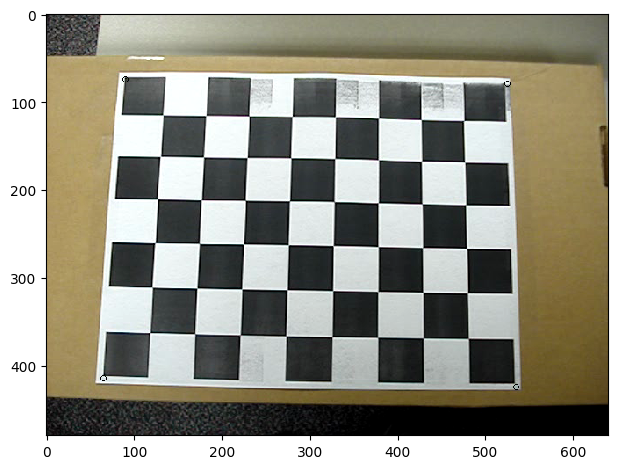

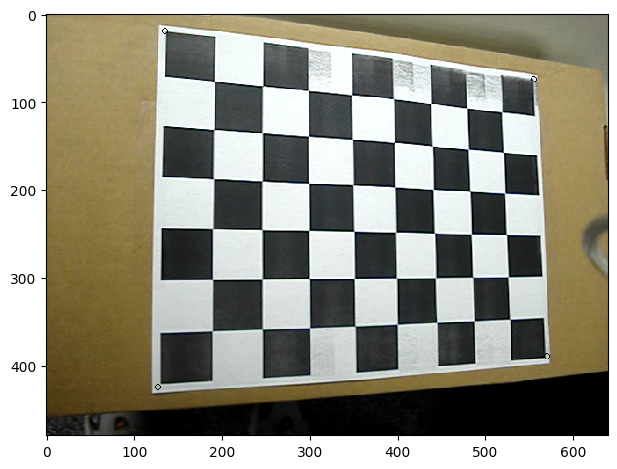

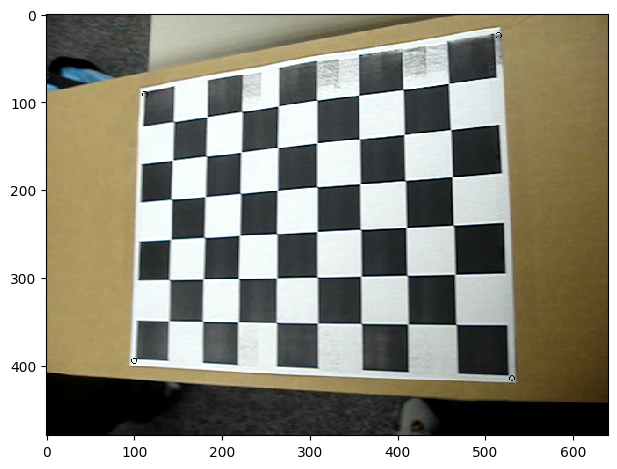

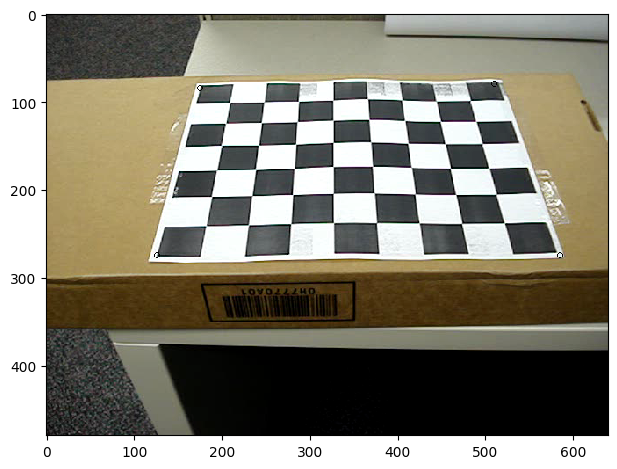

In [30]:
images = ["images2.png", "images9.png", "images12.png", "images20.png"]
images = [f"{content_path}/{img}" for img in images]
Hs = []
ims_pts = [[[75, 90], [80, 525], [415, 65], [425, 535]],
           [[20, 135], [75, 555], [425, 127], [390, 570]],
           [[92, 112], [25, 515], [395, 100], [415, 530]],
           [[85, 175], [80, 510], [275, 126], [275, 585]]]
world_coord = np.array([[7, 7, 0, 0],
                        [0, 9, 0, 9],
                        [1, 1, 1, 1]])
world_pts = np.array([[7, 0], [7, 9], [0, 0], [0, 9]])
Hs = []
for i in range(len(images)):
    im_name = images[i]
    im = io.imread(im_name)

    imPts = ims_pts[i]

    origin = imPts[2]

    pixel_coord = np.zeros((3, 4))
    # Replace "pass" statement with your code
    pixel_coord = np.array([imPts[0] + [1], imPts[1] + [1], imPts[2] + [1], imPts[3] + [1]]).T
    # END OF YOUR CODE

    H = None
    # Compute H using homography2d in the following, basically you only
    # need to find the right inputs for the homography2d function
    # Replace "pass" statement with your code
    H = homography2d(world_pts, pixel_coord[:2].T)
    # END OF YOUR CODE

    Hs.append(H)

    plotPts(imPts, im, False)

In [31]:
assert np.all(np.abs(np.array(solution_dict['Hs']) - np.array(Hs)) < 1e-6)

# Computing the Intrinsic and Extrinsic parameters (30 points)

Now given the four homographies, follow the instructions in section 2.4.4 to compute the intrinsic parameters and extrinsic parameters. We need to linearize the two constraints in Eq 2.19 and 2.20 into two equations in a homogeneous system as in Eq 2.25. Then solve for b and estimate the intrinsic parameters as described on page 21. Print the computed matrix $B$ and the intrinsic parameters. Then compute and print $R$, $t$ for each image .

Verify that your rotation matrix is in fact a rotation matrix, print $\mathbf{R}^T \mathbf{R}$, is it an identity as it should be? We can enforce $\mathbf{R}$ to be a rotation matrix by SVD decomposition of $\mathbf{R}$ and setting the singular values to ones, i.e., set the rotation matrix to $UV^T$ where $\mathbf{R}=U\sum V^T$.

Print the new $R$ and $\mathbf{R}^T \mathbf{R}$ after enforcing the rotation matrix constraints.

In [32]:
# We will assign the correct values to necessary variables even if the previous calculation is incorrect or shifted
# due to compounding deviations, ensuring that students can still proceed with following parts of the coding.

Hs = solution_dict['Hs']

In [33]:
# Function to calculate vij
def VIJ(H, i, j):
    """Calculates the VIJ for a given homography matrix H and indices i, j."""
    H = np.transpose(H)
    return [H[i - 1, 0] * H[j - 1, 0],
            H[i - 1, 0] * H[j - 1, 1] + H[i - 1, 1] * H[j - 1, 0],
            H[i - 1, 1] * H[j - 1, 1],
            H[i - 1, 2] * H[j - 1, 0] + H[i - 1, 0] * H[j - 1, 2],
            H[i - 1, 2] * H[j - 1, 1] + H[i - 1, 1] * H[j - 1, 2],
            H[i - 1, 2] * H[j - 1, 2]]

def compute_V(Hs):
    """Computes the V matrix."""
    V = []
    for i in range(len(Hs)):
        H = Hs[i]
        Vi = None
        # Replace "pass" statement with your code
        Vi = np.vstack((VIJ(H, 1, 2), np.array(VIJ(H, 1, 1)) - np.array(VIJ(H, 2, 2))))
        # END OF YOUR CODE
        V.append(Vi)

    V = np.vstack(V)  # Stack the rows of V on top of each other
    return V

def compute_params(V):
    """Computes the matrix 𝐵, intrinsic parameters 𝑢0, 𝑣0, 𝛼, 𝛽 and 𝛾."""
    u, s, vh = svd(V)
    b = np.transpose(vh)[:, -1]

    B = np.array([[b[0], b[1], b[3]],
                  [b[1], b[2], b[4]],
                  [b[3], b[4], b[5]]])
    v0 = None
    lambd = None
    alpha = None
    beta = None
    gamma = None
    u0 = None
    # Replace "pass" statement with your code
    v0 = (B[0][1] * B[0][2] - B[0][0] * B[1][2]) / (B[0][0] * B[1][1] - B[0][1]**2)
    lambd = B[2][2] - (B[0][2]**2 + v0 * (B[0][1] * B[0][2] - B[0][0] * B[1][2])) / B[0][0]
    alpha = np.sqrt(lambd / B[0][0])
    beta = np.sqrt(lambd * B[0][0] / (B[0][0] * B[1][1] - B[0][1]**2))
    gamma = -B[0][1] * alpha**2 * beta / lambd
    u0 = gamma * v0 / beta - B[0][2] * alpha**2 / lambd
    # END OF YOUR CODE

    return B, u0, v0, alpha, beta, gamma

def transform_rt(H, A, u_preview=False):
    """Computes the extrinsic parameters 𝑅, 𝑡 and enforces valid rotation matrix constraints."""
    A_inv = linalg.inv(A)
    # make original R
    r1 = None
    r2 = None
    r3 = None
    t = None
    # Replace "pass" statement with your code
    h1 = np.matmul(A_inv, H[:, 0])
    h2 = np.matmul(A_inv, H[:, 1])
    h3 = np.cross(h1, h2)

    r1 = h1 / np.linalg.norm(h1)
    r2 = h2 / np.linalg.norm(h1)
    r3 = h3 / np.linalg.norm(h3)
    t = np.matmul(A_inv, H[:, 2]) / np.linalg.norm(h1)
    # END OF YOUR CODE

    R= np.transpose(np.array([r1,r2,r3]))

    if u_preview:
        print("original R:", R)
        print("original RtR:", np.matmul(np.transpose(R), R))

    ur, sr, vhr = svd(R)

    # make R'
    R_prime = None
    # Replace "pass" statement with your code
    R_prime = np.matmul(ur, vhr)
    # END OF YOUR CODE

    if u_preview:
        print("new R:", R_prime)
        print("new RtR:", np.matmul(np.transpose(R_prime), R_prime))

    return R_prime, t

V = compute_V(Hs)

# Compute B, u0, v0, alpha, beta, gamma
B, u0, v0, alpha, beta, gamma = compute_params(V)
A = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])

# Extrinsic parameters (R, t)
Rs = []
ts = []
for i, (H, img_name) in enumerate(zip(Hs, images)):
    print("\n" + img_name)
    R, t = transform_rt(H, A, u_preview=True)
    print("--------")
    Rs.append(R)
    ts.append(t)


materials/images2.png
original R: [[-0.98853878  0.00956869 -0.14967906]
 [ 0.02259516  0.99152141 -0.01780728]
 [ 0.14926667 -0.01930916 -0.98857427]]
original RtR: [[ 1.00000000e+00  1.00623522e-02 -3.23207457e-18]
 [ 1.00623522e-02  9.83579118e-01 -2.95059789e-18]
 [-3.23207457e-18 -2.95059789e-18  1.00000000e+00]]
new R: [[-0.98862558  0.01468455 -0.14967906]
 [ 0.0175449   0.99968749 -0.01780728]
 [ 0.14937079 -0.02023084 -0.98857427]]
new RtR: [[1.00000000e+00 1.36391959e-16 3.79561503e-17]
 [1.36391959e-16 1.00000000e+00 1.66133241e-17]
 [3.79561503e-17 1.66133241e-17 1.00000000e+00]]
--------

materials/images9.png
original R: [[-0.99465419  0.0204871  -0.09836467]
 [-0.00624117  0.94155081  0.36101798]
 [ 0.10307324  0.36437066 -0.92735668]]
original RtR: [[ 1.00000000e+00  1.13029037e-02  1.12609862e-17]
 [ 1.13029037e-02  1.01970362e+00 -8.84589729e-19]
 [ 1.12609862e-17 -8.84589729e-19  1.00000000e+00]]
new R: [[-0.99481518  0.0258291  -0.09836467]
 [-0.01148564  0.9324881

In [34]:
assert np.all(np.abs(solution_dict['B2'] - B) < 1e-6)
assert np.all(np.abs(solution_dict['u02'] - u0) < 30)
assert np.all(np.abs(solution_dict['v02'] - v0) < 30)
assert np.all(np.abs(solution_dict['alpha2'] - alpha) < 50)
assert np.all(np.abs(solution_dict['beta2'] - beta) < 50)
assert np.all(np.abs(solution_dict['gamma2'] - gamma) < 1e-1)
assert np.all(np.abs(solution_dict['A2'] - A) < 50)

In [35]:
assert np.all(np.abs(np.array(solution_dict['Rs2']) - np.array(Rs)) < 1e-1)
assert np.all(np.abs(np.array(solution_dict['ts2']) - np.array(ts)) < 1.)

# Improving accuracy (30 points)

Since we used four manually entered points to compute the homography. A small error in one of the points will directly effect the computed homography. To fix this we are going to estimate the homography from all grid points.

First given the computed homographies from Section 2, compute the approximate location of each grid corner in the image. (Hint : This can be done since we know the 3d locations of the grid corners and the approximate homography. Call these points $p_{approx}$. Create a figure with the image and approximate grid locations. Call this “Figure 1 : Projected grid corners ”

Figure 1 : materials/images2.png Projected grid corners
74 90
80 524
415 64
424 534


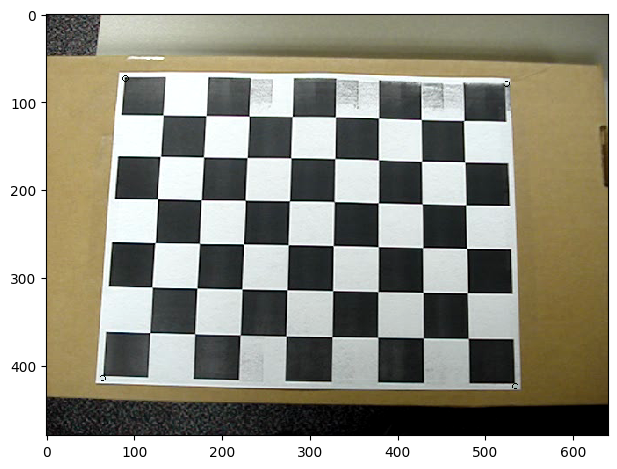

Figure 1 : materials/images9.png Projected grid corners
19 134
75 555
424 126
390 570


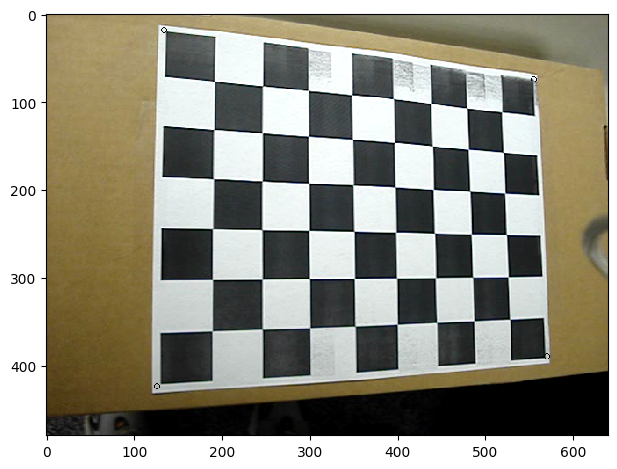

Figure 1 : materials/images12.png Projected grid corners
92 111
25 515
395 100
415 530


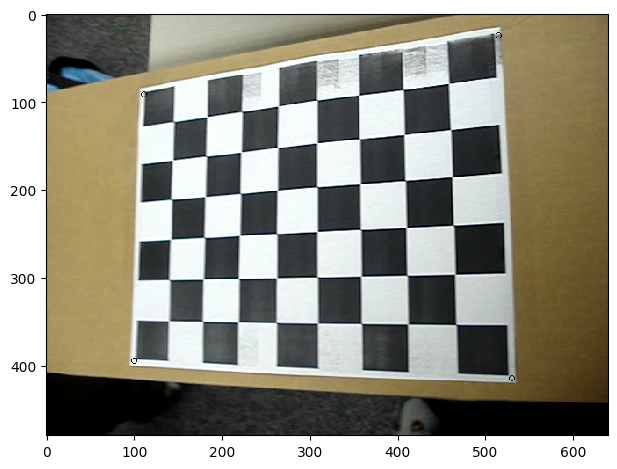

Figure 1 : materials/images20.png Projected grid corners
84 175
79 510
274 125
274 584


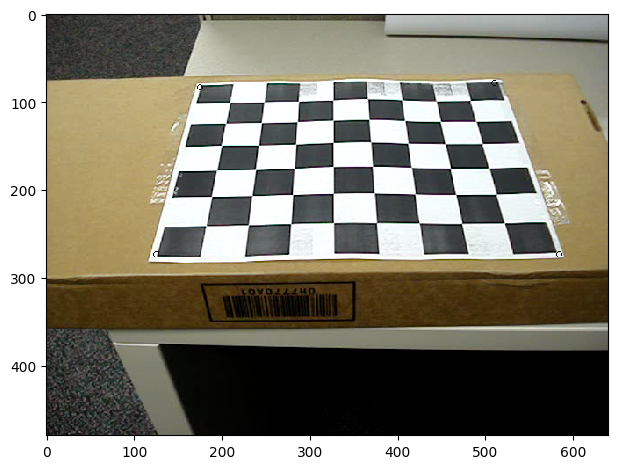

In [36]:
# complete the `project_grid_corners` function
def project_grid_corners(H, world_coord, img_path):
    """Computes the approximate location of each grid corner in the image."""
    img = io.imread(img_path)
    pts = None
    # Replace "pass" statement with your code
    pts= []
    for coord in world_pts:
        coord_h = np.append(coord, 1)
        pt = np.dot(H, coord_h)
        pt = pt[:2] / pt[2]
        pts.append(pt)
    # END OF YOUR CODE
    pts = np.array(pts)
    print(f"Figure 1 : {img_path} Projected grid corners")
    plotPts(pts.astype(int), img)

    errors = [[ims_pts[i][j][0] - pts[j][0], ims_pts[i][j][1] - pts[j][1]] for j in range(len(pts))]
    return errors

errors = []
for i in range(len(Hs)):
  err = project_grid_corners(Hs[i], world_coord, images[i])
#   print("--------------------------------")
  errors.append(err)


In [37]:
assert np.all(np.abs(np.array(errors)) < 1e-6)

Second, using the provided Harris function detect Harris corners in the image and display them. Use the following parameter values for the Harris detection : blockSize = 2, ksize = 3, k = 0.04.
``` python
dst = cv2.cornerHarris(rgb2gray(im), blockSize, ksize, k);
```
See [here](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345) for documentation. Call this “Figure 2 : Harris corners ”.

Third, compute the closest Harris corner to each approximate grid corner. Let these closest Harris corners be $p_{correct}$. Create a figure with the image and $p_{correct}$ overlayed. Call this “Figure 3 : grid points ”.

materials/images2.png Figure 2: Harris Corners


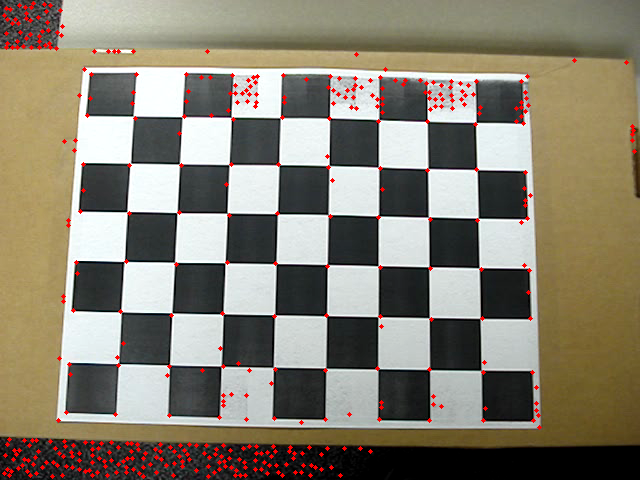

materials/images2.png Figure 3: grid points


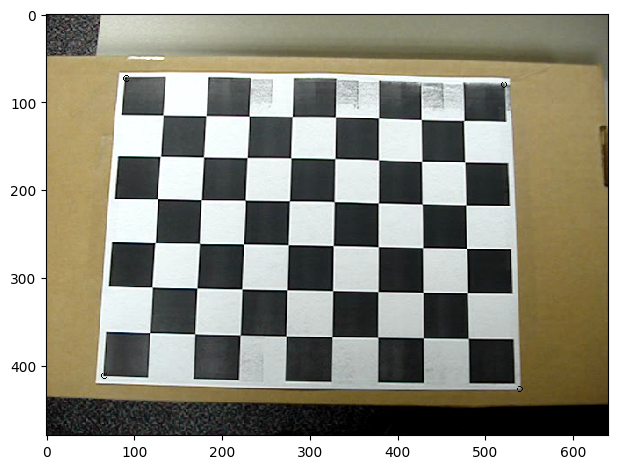

materials/images9.png Figure 2: Harris Corners


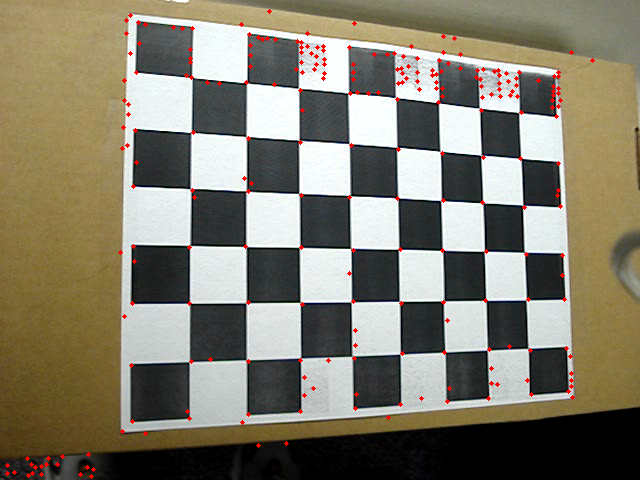

materials/images9.png Figure 3: grid points


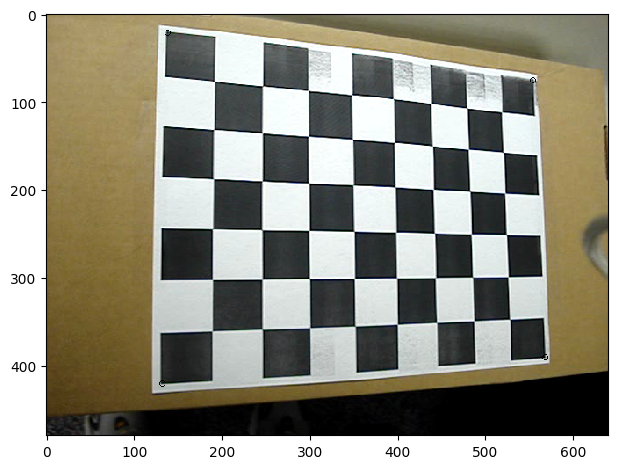

materials/images12.png Figure 2: Harris Corners


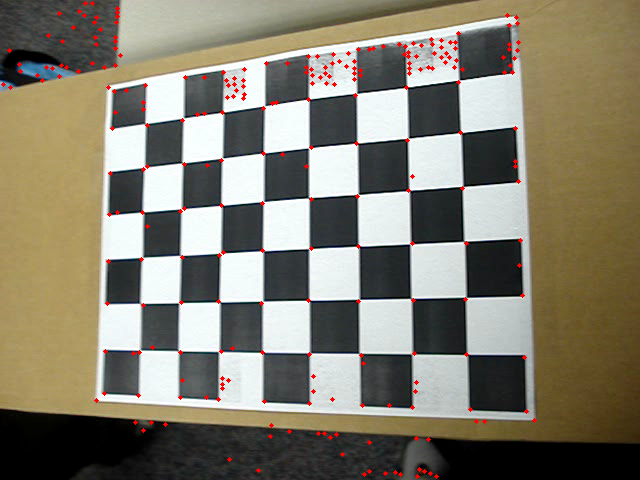

materials/images12.png Figure 3: grid points


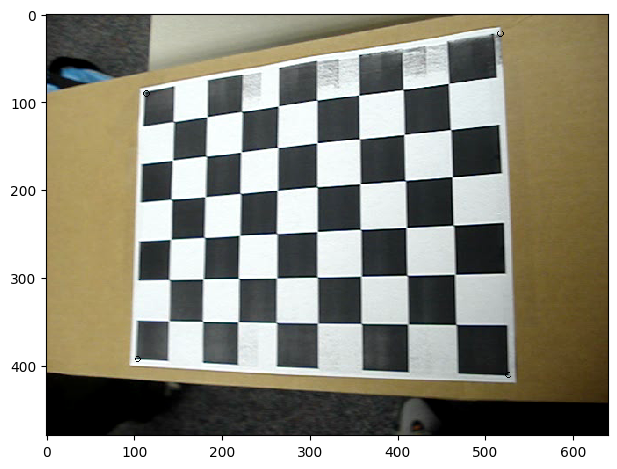

materials/images20.png Figure 2: Harris Corners


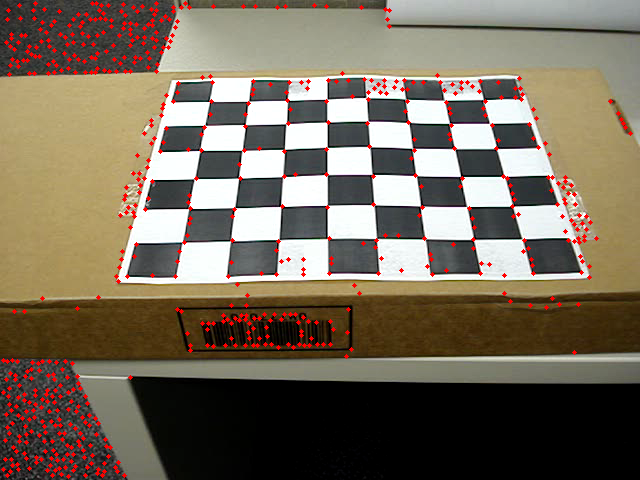

materials/images20.png Figure 3: grid points


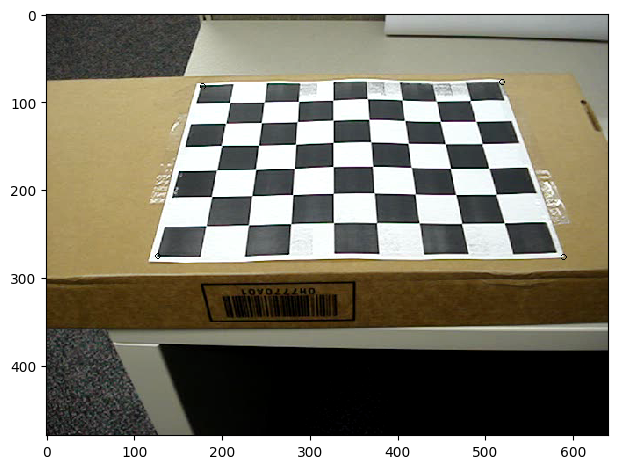

[array([74, 91]), array([ 81, 521]), array([412,  66]), array([427, 539])]


In [38]:
p_corrects = []
for i in range(len(images)):
    img = cv2.imread(images[i])
    # note that you need to make a gray image as the input for the harris function
    dst = None
    # Replace "pass" statement with your code
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 1.5)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    # END OF YOUR CODE
    out = peak_local_max(dst, min_distance=3, threshold_abs=500)
    eyeballed = ims_pts[i]

    ed = euclidean_distances(eyeballed, out, squared=True)
    eachmax = np.argmin(ed, axis=1)
    p_correct = [out[eachmax[0], :], out[eachmax[1], :],
                 out[eachmax[2], :], out[eachmax[3], :]]
    p_corrects.append(p_correct)

    for item in out:
        image = cv2.circle(img, (item[1], item[0]),
                           radius=2, color=(0, 0, 255), thickness=-1)
    print("{} Figure 2: Harris Corners".format(images[i]))
    cv2_imshow(img)
    print("{} Figure 3: grid points".format(images[i]))
    plotPts(p_correct, io.imread(images[i]), pt=False)

print(p_corrects[0])


**Grader will grade the above code based on the plot you show. Please neglect "YOU ANSWER HERE"**

YOUR ANSWER HERE

Finally, compute a new homography from $p_{correct}$, print H.

Repeat this for the other three images. Then use the homographies to estimate $R$, $t$ for each image. Report your $R$’s, and $t$’s . Save your results, you will need to use them in Part III.

Using the new computed $H$, compute the errors between points in $p_{correct}$ and points you get by projecting grid corners to the image (Hint there is no need to use $R$, $t$ for projecting). Call this $err_{reprojection}$. Report your result.

Now repeat the process using 4 images. We will be using the functions, such as `compute_V` and `transform_rt`, you implemented earlier.

In [39]:
def homography_automated(ims_pts):
    Hs = []
    for i in range(len(ims_pts)):
        imPts = ims_pts[i]
        imPts2 = np.array(imPts)
        H2, _ = cv2.findHomography(world_pts, imPts2)
        Hs.append(H2)

    V = compute_V(Hs)
    B, u0, v0, alpha, beta, gamma = compute_params(V)
    A = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])

    # Extrinsic parameters (R, t)
    Rs = []
    ts = []
    errors = []
    for i, (H, img_name) in enumerate(zip(Hs, images)):
        print("\n" + img_name)
        R, t = transform_rt(H, A, u_preview=True)
        print("t:", t)
        print("--------")
        Rs.append(R)
        ts.append(t)

        # compute err_reprojection
        p_predict = None
        # Replace "pass" statement with your code
        points = np.matmul( H, world_coord)
        for j in range(points.shape[1]):
          points[:, j] /= points[2, j]
        p_predict = points.T
        # END OF YOUR CODE
        for j in range(len(p_predict)):
            errors.append(p_predict[j][:2] - ims_pts[i][j])
    return A, Hs, Rs, ts, errors


In [40]:
A, Hs, Rs, ts, errors=homography_automated(p_corrects)


materials/images2.png
original R: [[-0.98206278  0.01998703 -0.18850082]
 [ 0.00977582  0.9900764  -0.02713231]
 [ 0.18830065 -0.03120168 -0.98169816]]
original RtR: [[ 1.00000000e+00 -1.58250070e-02 -2.21425802e-17]
 [-1.58250070e-02  9.81624312e-01  2.37333057e-18]
 [-2.21425802e-17  2.37333057e-18  1.00000000e+00]]
new R: [[-0.98199607  0.01229458 -0.18850082]
 [ 0.01772165  0.99947475 -0.02713231]
 [ 0.18806823 -0.02998437 -0.98169816]]
new RtR: [[ 1.00000000e+00  4.47101312e-17  3.43786558e-17]
 [ 4.47101312e-17  1.00000000e+00 -2.43547285e-17]
 [ 3.43786558e-17 -2.43547285e-17  1.00000000e+00]]
t: [ 3.28467    -4.58689087 13.29859612]
--------

materials/images9.png
original R: [[-0.99541664  0.01656871 -0.09212594]
 [-0.00877841  0.93892617  0.35522294]
 [ 0.09522948  0.35690248 -0.93023087]]
original RtR: [[1.00000000e+00 9.25259167e-03 6.73040158e-18]
 [9.25259167e-03 1.00923626e+00 6.71520730e-17]
 [6.73040158e-18 6.71520730e-17 1.00000000e+00]]
new R: [[-0.99552448  0.02106

In [41]:
assert np.all(np.abs(errors) < 1e-6)

Compare your results to your previous results and those of part 2 .

Can you suggest a way this can be done automatically (i.e without first letting the user manually select the 4 corners)? Please replace "YOUR ANSWER HERE" in the next cell by your own answer for the question.

The Harris algorithm is capable of identifying all necessary points within an image. However, extra edges must be recognized and removed. For detecting specific points, an algorithm with accurate corner detection capabilities is needed. It's evident that the Harris corners algorithm successfully pinpoints nearly every essential point on the grid. Given the known count of horizontal and vertical blocks, it's possible to select the four extreme corners. With the block dimensions also known, it's feasible to determine the points that serve as the grid's four corners by measuring the distances between them. Alternative methods such as the Shi-Tomasi corner detection, FAST corner detection, and SIFT feature extraction are available for assisting in this process.

# Part III: Augmented Reality 101 (50 points)

# Augmenting an Image (30 points)

Now we would like to use our computed homographies from part II to map a clip art image onto the grid such that it seems to be part of the grid. The image should be synthesized such that the clip art bottom left corners is the same as the grids (0,0) corner. When fitting the clip art you should rescale it to fit the grid while keeping the clip art aspect ratio. Using your computed homography find a way to map your image on the grid such that you image will have the same projective distortion as the grid. If the clip art have any white pixels you should make these pixels appears transparent when overlayed over the grid. For each image of the four images in Part II, create a figure with the original image and your virtual clip art overlayed over the grid.

There are 10 images provided in the "materials" folder. You only need select **one of them** based on the last digit in your **netid**, e.g. if your netid is abc56, use the images named as "6.jpg" or "6.png".



255 0
(500, 500, 3)


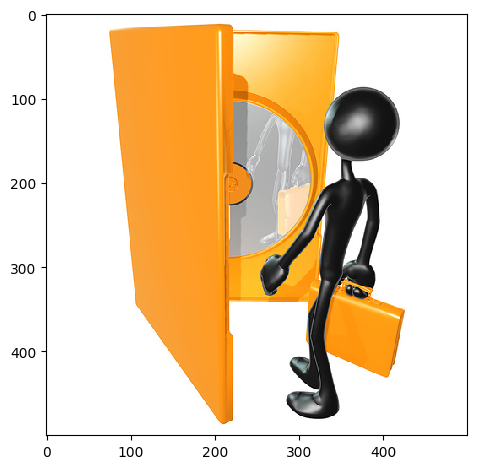

In [42]:
clip_id = "9.jpg" # select and input your file name here
clip_fn = f"{content_path}/{clip_id}"

clip = io.imread(clip_fn)
if clip.shape[-1] > 3:
    clip = rgba2rgb(clip)
print(np.max(clip,axis=None),np.min(clip,axis=None))
print(clip.shape)
trans_clip = (255-clip)
io.imshow(clip)
io.show()

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


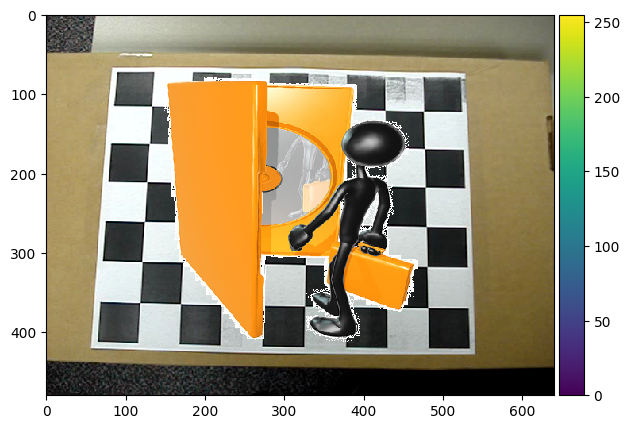

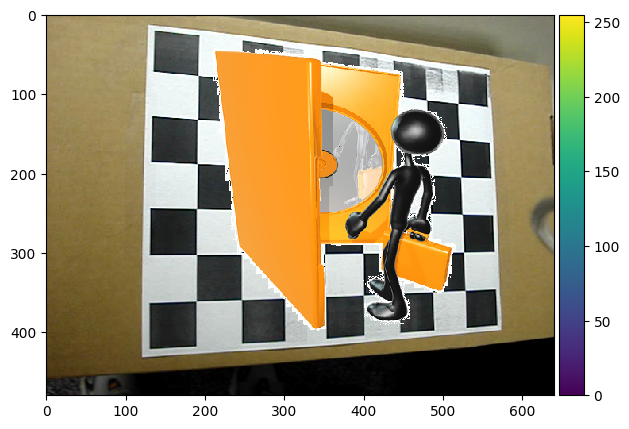

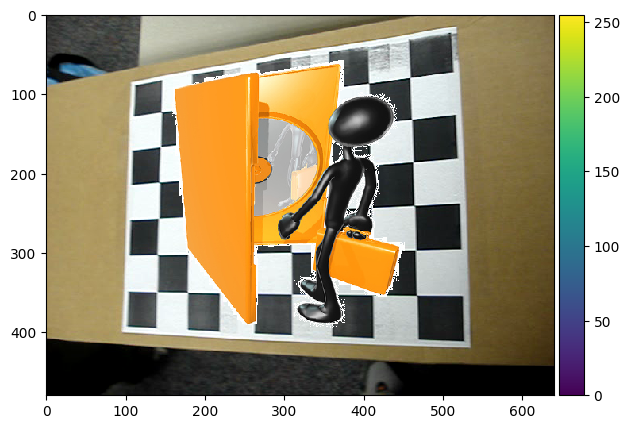

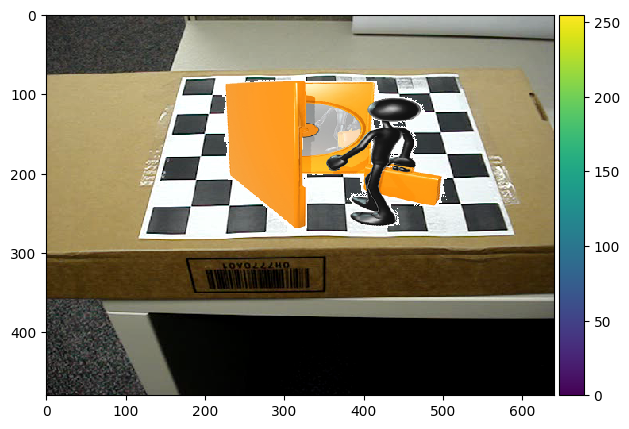

In [43]:
def read_and_transform_image(images, Hs):
    for i in range(len(images)):
        clip = io.imread(clip_fn)
        if clip.shape[-1] > 3:
            clip = rgba2rgb(clip)
        if np.max(clip, axis=None) <= 1.0:
            clip *= 255.0
        im = io.imread(images[i])
        # transformed: an empty image with the same dimensions as the input image,
        # where the transformed clip will be added.
        transformed = np.zeros(im.shape)
        # pixel_count: a 2D array with the same dimensions as the input image,
        # where the number of times each pixel is updated with `clip` will be stored.
        pixel_count = np.zeros((im.shape[0], im.shape[1]))

        H = Hs[i]
        x_top = clip.shape[0]

        # Iterate through the pixels of the clip image (x and y coordinates). For each non-white pixel,
        # calculate and apply the transformation using the homography matrix H, and update the
        # transformed image and the pixel_count accordingly.
        for x in range(clip.shape[0]):
            for y in range(clip.shape[1]):
                if np.min(clip[x, y, :], axis=None) == 255:
                    continue
                # Update the corresponding pixel in the transformed image
                # by adding the clip image pixel value to it, and increment
                # the pixel_count for the transformed pixel location.
                # Replace "pass" statement with your code
                x_reshaped = (7 * abs(x_top - x)) / (x_top)
                y_reshaped = (9 * y) / (x_top)

                point = np.array([x_reshaped, y_reshaped , 1])
                trans = np.matmul(H, point.T)
                trans /= trans[2]
                trans = np.int64(trans)
                trans = trans[0:2]
                transformed[trans[0], trans[1], :] += clip[x, y, :]
                pixel_count[trans[0], trans[1]] += 1
                # END OF YOUR CODE

        for ii in range(im.shape[0]):
            for jj in range(im.shape[1]):
                if (pixel_count[ii, jj] > 0):
                    im[ii, jj, :] = 0

        pixel_count = np.where(pixel_count == 0, 1, pixel_count)

        for ii in range(3):
            transformed[:, :, ii] = transformed[:, :, ii] / pixel_count

        im = im + transformed
        im = im.astype(int)
        im = np.clip(im, 0, 255)

        io.imshow(im)
        io.show()

read_and_transform_image(images, Hs)

**Grader will grade the above code based on the plot you show. Please neglect "YOU ANSWER HERE"**

YOUR ANSWER HERE

# Augmenting an Object (20 points)

Now we would like to augment our images with 3D objects. For our purposes we are going to use a cube as a virtual object. We will only render the cube as a wire frame and we would like its base to be located on the 3x3 grid of squares in the bottom left corner of our grid. The cube should be standing up from the grid. First print the 3D coordinates of the cube. Then, find a way to use your computed $H$, $K$, $R$, $t$ to synthesize new images with the virtual cube inserted.


In [44]:
def create_cube(num_points, side_length=7):
    cube_coords = np.array([[0, 0, 0, 1], [side_length, side_length, side_length, 1]])

    for i in range(1, num_points + 1):
        val = side_length / num_points * i
        new_points_x = np.array([[val, 0, 0, 1], [val, 0, side_length, 1], [val, side_length, 0, 1], [val, side_length, side_length, 1]])
        new_points_y = np.array([[0, val, 0, 1], [side_length, val, 0, 1], [0, val, side_length, 1], [side_length, val, side_length, 1]])
        new_points_z = np.array([[0, 0, val, 1], [0, side_length, val, 1], [side_length, 0, val, 1], [side_length, side_length, val, 1]])

        cube_coords = np.append(cube_coords, new_points_x, axis=0)
        cube_coords = np.append(cube_coords, new_points_y, axis=0)
        cube_coords = np.append(cube_coords, new_points_z, axis=0)

    return cube_coords

sidelength = 3
cube_coords = create_cube(35,3)
cube_coords = np.transpose(cube_coords)

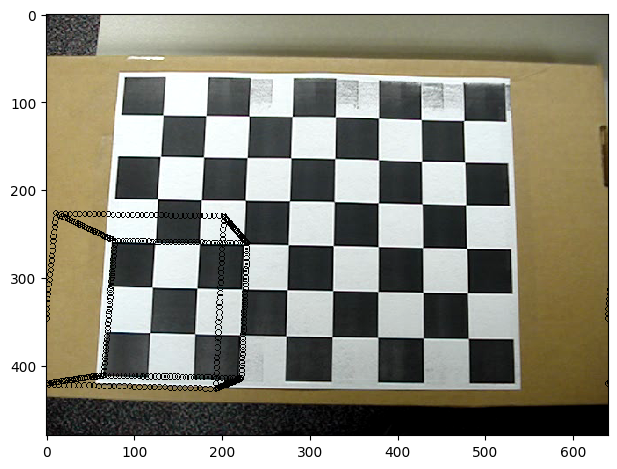

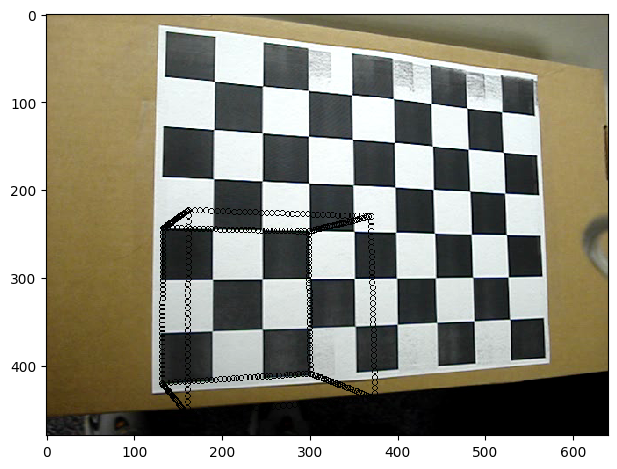

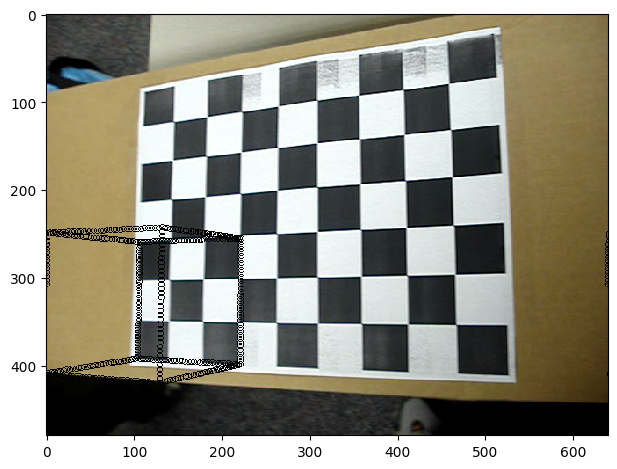

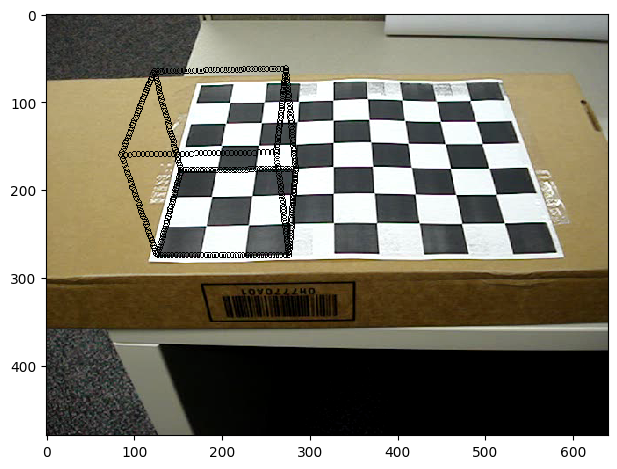

In [45]:
def process_images(images, Hs, Rs, ts, cube_coords):

    for i in range(len(images)):
        image = io.imread(images[i])
        H, R, t = Hs[i], Rs[i], ts[i]
        transformed_coords = None
        # Replace "pass" statement with your code
        E = np.hstack((R, t.reshape(3, 1)))
        P = np.dot(A, E)
        transformed_coords = np.matmul(P, cube_coords)
        # END OF YOUR CODE

        predicted_points = []
        for ii in range(cube_coords.shape[1]):
            ptx, pty = int(transformed_coords[0, ii] / transformed_coords[2, ii]), int(transformed_coords[1, ii] / transformed_coords[2, ii])
            if ptx < 0 or pty < 0:
                continue
            predicted_points.append([ptx, pty])
        plotPts(predicted_points, image, pt=False)

process_images(images, Hs, Rs, ts, cube_coords)

**Grader will grade the above code based on plots you show. Please neglect "YOU ANSWER HERE"**

YOUR ANSWER HERE

# Extra credit (20 points)

Do one of the following:
1. Instead of augmenting a cube, augment a general mesh from a 3D file of your choice.
2. Can you find a way to estimate the intrinsic and extrinsic parameters from only two images of the grid. What assumptions on the intrinsic parameters are needed to achieve this? (Hint: the answer can be found in Sec 2.4)


**Grader will grade the above code based on the outputs. Please neglect "YOU ANSWER HERE"**

YOUR ANSWER HERE

Answer to Question 2: Estimating both intrinsic and extrinsic camera parameters from merely two images of a grid can pose a challenge, yet it's possible under specific conditions. One crucial condition is having a known or constant aspect ratio, as highlighted in Section 2.4. Furthermore, assuming the principal point is centered on the image sensor simplifies the camera matrix, narrowing the estimation process down to determining the focal lengths (fx and fy) and the camera's rotation and translation. These parameters can be approximated by identifying the grid points, matching them, calculating the fundamental matrix, deriving the essential matrix with the preset aspect ratio, breaking down the essential matrix to obtain rotation and translation matrices, and ultimately, pinpointing the focal length and principal point. Nevertheless, it’s essential to acknowledge that employing multiple images from varied poses typically provides a more reliable and precise calculation of these parameters than using only two images.
